In [1]:
import numpy as np
from numpy.random import randint,uniform,choice
import matplotlib.pyplot as plt
import datetime
import time
from scipy.integrate import odeint

from numba import jit,njit,vectorize

In [2]:
import numpy as np
from numpy.random import randint,uniform,choice

# |  L  |  L  |  L  |  L  |  L  |  L  |  L  |  L  | 
# |  N  |  N  |  N  | *N  | *N  |  N  |  -  |  -  | 
# |  -  |  -  |  -  | *H  | *H  |  H  |  H  |  H  |
# ___Only Networks__  (*OVERLAP) _______Homes_________

n_pop = 10000    # Total population
n_loc = 1     # Total number of locations
n_net = 1      # Total number of networks
n_overlap = 1  # Include the possibility of overlap between work and home locations
n_hospitals = 1 # Set the number of hospitals.

n_asym = 10      # Initial number of asymptomatics

# Initial populations ###########

n0 = np.array([n_pop-n_asym, n_asym, 0, 0, 0],dtype=np.int64)
           # [S,            A,      I, R, H ]

##################################


labels      = np.array([0,1,2,3,4],dtype=np.int64) # Number of states a person can be in, [S,A,I,R,H] (Not very important, just for bookkeeping)
person_attr = 4           # 4 attributes for a person: state, home, network, current location

### Rates #############

n_states = len(labels)
n_events = 6              # Different events in the model (currently) S->A, A->I, A->R, I->R, I->H, H->R
    
rate_array = np.zeros((n_states,n_states))

rate_array[0][1] = 0.45  # S -> A
rate_array[1][2] = 0.205 # A -> I
rate_array[1][3] = 0.136 # A -> R
rate_array[2][3] = 0.1   # I -> R
rate_array[2][4] = 0.25  # I -> H
rate_array[4][3] = 0.1   # H -> R


Cpars = np.array([0,  1,  1,  0,  0.1,  0.1],dtype=np.float64)  # Transmissivity of different individuals. Asymptomatic and symptomatics 
                                     # are just as infectious, hospitalised and quarantined are 10 times less infectious
       # Contact parameters


total_loc_confined_time = 0

days_bw_hq_tests = 1
days_bw_lq_tests = 1

dt = 0.1

In [3]:
## CREATE POPULATION #####

def create_person(state, home):                  # Function to create a person with certain attributes
    net = randint(0,n_net)                       # Assign a random network from 0 to n_net (here, 200)
    return np.array([state, home , net , home ]) # Create a person in state 'state', initially at home


pop = np.zeros((n_pop,person_attr),int)          # Empty population
link_weight = np.zeros(n_pop,float)              # Array for link weights
n_per_location=np.zeros((n_loc,len(labels)),int) # Array to hold total number of individuals per state 
                                                 # for all locations: both homes and networks

for i in range(0,n_pop):
    home = randint(n_overlap-1,n_loc)              # Assign random homes for remainder with random network
    pop[i] = create_person(0,home)

    n_per_location[  pop[i][3] ][0] +=  1          # Increment susceptibles in each person's location

    link_weight[i] = 1                             # This number must be between 0 and 1 (probability of shifting along link)

        
r = choice(n_pop,size=n_asym,replace=False)        # Generate n_inf random numbers (r) from the total population without replacement

np.put_along_axis(pop[:,0],r,1,axis=0)             # Set population members at r to infected (1)

i_locs = pop[r][:,3]                               # Find locations of infected individuals (with repetition), eg. [1,2,1,1,3,1,2,3..] etc

np.add.at(n_per_location[:,0],i_locs,-1)           # Decrement number of infected at these locations (repetition increments twice)
np.add.at(n_per_location[:,1],i_locs,+1)           # Increment number of susceptible at these locations (idem)

if(np.sum(n_per_location) != n_pop):
    print("Error: Problem with assigning infected individuals to location. Mismatch in total population number.")

In [4]:
@vectorize
def setval(l,m):
    return np.int64(m)

@vectorize
def randdate(l):
    return randint(np.int64(l))

@njit
def rnd(x, decimals, out):
    return np.round_(x, decimals, out)

@njit
def log_output(lq_tests_conducted, hq_tests_conducted, tests_conducted, results_declared, locations_moved):
    
    print("# LQ Tests Done in total  : "+str(lq_tests_conducted))
    print("# HQ Tests Done in total  : "+str(hq_tests_conducted))
    print("# ALL Tests Done in total : "+str(tests_conducted))
    print("# Results Given in total  : "+str(results_declared))
    print("# Locations Moved in total: "+str(locations_moved))

@njit
def TLR(rate, Tpars, T, home_loc_state, quarantine_confined, test_frac):
    
    pop = np.copy(quenched_pop)
    n_per_location = np.copy(quenched_n_per_location)
    link_weight = np.copy(quenched_link_weight)
    n = np.copy(n0)
    
    is_confined = np.zeros(n_pop,np.bool_)               # Boolean array, is confined? (Initial values, all "no".)
    being_tested= np.zeros(n_pop,np.bool_)               # Boolean array, is being tested?
    loc_confined= np.zeros(n_loc,np.bool_)               # Boolean array, is the location confined? <---NEW

    test = Tpars
    test_result = np.zeros(n_pop,dtype=np.int64)                # Array to hold results of test (+1 positive, -1 negative)

    loc_confined_time = setval(np.zeros(n_loc), -1000)
    next_test_date = setval(np.zeros(n_pop), 7)                # Don't conduct a test before this date per person. (Initially all day 0)    
    result_declared_date = setval(np.zeros(n_pop),-1000)       # Declare the result of last test on this day (initiall -1000)    
    
    
    tests_conducted    = 0
    hq_tests_conducted = 0
    lq_tests_conducted = 0
    results_declared   = 0
    locations_moved    = 0
    
    t = 0.0
    
    v = np.array([[-1, 0, 0, 0, 0, 0],              # Array to denote change per state per event
                  [ 1,-1,-1, 0, 0, 0],              # The row indexes the state variables, and the
                  [ 0, 1, 0,-1,-1, 0],              # column indexes the events. The number represents
                  [ 0, 0, 1, 1, 0, 1],
                  [ 0, 0, 0, 0, 1,-1]],np.float64)  # the change in that particular state, given an event.

    
    transitions = np.zeros((n_states,n_states),np.int64)
    r = np.zeros(n_events,np.float64)                          # Empty array to store rates per event
    K = np.zeros(n_events,np.float64)               # Empty array to store number of events that occur in dt (Poisson distributed)
    
    alpha = 1 - Cpars[5]   # Effective reduction in transmissivity of infected individuals (BOTH A and I)
    
    
#     #### TESTS #################################
    
    tests_available_daily =np.int64(test_frac/100 * n_pop)
    tests_available_now   =np.int64(test_frac/100 * n_pop)  # test_frac% of population number of tests available
    
    lq_tests_daily      =np.int64(test[0][3] * tests_available_daily)
    lq_tests_available  =np.int64(test[0][3] * tests_available_daily)
    
    hq_tests_daily      =np.int64(test[1][3] * tests_available_daily)
    hq_tests_available  =np.int64(test[1][3] * tests_available_daily)
    
    if(lq_tests_daily + hq_tests_daily > tests_available_daily):
        print("More LQ + HQ tests available than total! Are you sure your test fractions for each test type are correct?")
    
    lq_sensitivity = test[0][0]
    lq_specificity = test[0][1]
    lq_result_delay= test[0][2]
    
    hq_sensitivity = test[1][0]
    hq_specificity = test[1][1]
    hq_result_delay= test[1][2]
    
#     ############################################
        
    output = np.zeros((np.int64(T+1),9),dtype=np.int64)
    
    output[0] = np.array([t,n[0],n[1],n[2],n[3],n[4], hq_tests_conducted, lq_tests_conducted, tests_available_now])
    
    day = np.int64(0)
    
    op_counter = np.int64(0)
 
    while(t<T):
       
        for i in range(0, n_loc):                 # Loop over locations
            
            
            indices = np.where(pop[:,3]==i)[0]    # Index in pop of individuals in this location
            N = len(indices)
            
            if(N==0):
                continue                           # If no one's in this location, skip this loop
            
            V = N - alpha*n_per_location[i][4]                                  # Assume one-to-one contact 
            
            conf_by_state_in_loc = np.zeros(n_states,np.int64) # Number of confined individuals by state in location
            
            if(quarantine_confined == True):       # If you want to reduce infectivity of confined individuals, find out how many there are
                conf_state = is_confined[indices]
                
                for m in range(0,N):               # Change the new "confined per state location" numbers
                    if(conf_state[m] == True):     # If the person is confined
                        conf_by_state_in_loc[pop[indices[m]][0]] += 1
                
            # This part can be done more efficiently using a matrix, but that's for later
            
            r[0] = rate[0][1] * n_per_location[i][0] * 1/V * (Cpars[1]*(n_per_location[i][1] - conf_by_state_in_loc[1]*alpha)  + Cpars[2]*(n_per_location[i][2]- conf_by_state_in_loc[2]*alpha) + Cpars[4]*n_per_location[i][4])
            r[1] = rate[1][2] * n_per_location[i][1]
            r[2] = rate[1][3] * n_per_location[i][1]
            r[3] = rate[2][3] * n_per_location[i][2]
            r[4] = rate[2][4] * n_per_location[i][2]
            r[5] = rate[4][3] * n_per_location[i][4]
            
            flag = False
            counter = 0
            
            while(flag == False):
                for j in range(0,n_events):
                    K[j] = np.random.poisson(r[j]*dt)
                    
                
                transitions[0][1] = K[0]
                transitions[1][2] = K[1]
                transitions[1][3] = K[2]
                transitions[2][3] = K[3]
                transitions[2][4] = K[4]
                transitions[4][3] = K[5]

                n_removed = np.sum(transitions,axis=1) # Number of people ideally needing to be removed

                for j in range(0,n_states):
                    if( n_per_location[i][j] < n_removed[j] and n_removed[j] != 0):
                        y=np.empty_like(transitions[j,:])
                        transitions[j,:] = rnd(transitions[j,:]/n_removed[j] * n_per_location[i][j],0,y)

                K[0] = transitions[0][1]
                K[1] = transitions[1][2]
                K[2] = transitions[1][3]
                K[3] = transitions[2][3]
                K[4] = transitions[2][4]
                K[5] = transitions[4][3]

                n_per_location[i] +=  rnd(np.dot(v,K),0,np.empty_like(n_per_location[i]))            # Change number per location by Sum_j v_ij K_j 
                
                
                if(np.any(n_per_location[i]<0)):
                    print("Negative populations! Shouldn't be happening!")
                    print(transitions)
                    print(n_per_location[i])
                    print("Rolling back")
                    n_per_location[i] -=  rnd(np.dot(v,K),0,np.empty_like(n_per_location[i]))
                    print(n_per_location[i])
                    print("Trying again...")
                    counter += 1
                    
                    if counter == 9:                        # Don't let more than 10 retries occur
                        print("Fatal error: 10 retries didn't get rid of negative populations")
                        break
                else:
                    flag = True
            

            if(np.all(transitions==0)):               # Skip this loop if no transitions need to occur
                continue
            
            
            done = np.zeros(len(indices),np.bool_)        # Array to make sure same individual isn't shifted more than once 
            for j in range(0,n_states):
                for k in range(0,n_states):
                    l=0
                    for m in range(0,len(indices)): # Go over everyone in this location
                        if(l==transitions[j][k]):
                            break

                        if(pop[indices[m]][0] == j and not done[m]):  # If they are j
                            pop[indices[m]][0] = k    # change them to k
                            n[j] -= 1                 # Decrement number of j
                            n[k] += 1                 # Increment number of k
                            
                            if(k==3): # If they recover,
                                is_confined[indices[m]] = False # Remove any confinement, and
                                
                                # Shift them home
                                if( pop[indices[m]][3] != pop[indices[m]][1] or pop[indices[m]][3] != pop[indices[m]][2] ):
                                    
                                    n_per_location[pop[indices[m]][3]][k] -= 1
                                    pop[indices[m]][3] = pop[indices[m]][1]   # Send them home
                                    n_per_location[pop[indices[m]][3]][k] += 1
                                    
                            elif(k==4):                 # If they are hospitalised
                                h = randint(n_hospitals)
                                n_per_location[pop[indices[m]][3]][k] -= 1 # Decrement the number of hospitalised in current (HOME or WORK) location
                                
                                pop[indices[m]][3] = h # Send them to a random hospital
                                n_per_location[pop[indices[m]][3]][k] += 1 # Increment the number of hospitalised (4) in current (hospital) location
                                
                                is_confined[indices[m]] =  False # Remove confinement   
                            
                            done[m] = True            # Don't repeat this index
                            l += 1

        for i in range(0,n_pop): 
            
            #### TESTING ###########################################
            
            p = test_frac/100 * dt     # Probability of testing someone (random) in time dt
            
            if (day >= next_test_date[i] and not being_tested[i] 
                and uniform(0.0,1.0) < p and tests_available_now>0): # Check if person i should be tested
                
                # If so, perform a test.
                being_tested[i]   = True            
                tests_conducted += 1
                
                tests_available_now -= 1                     # Reduce number of tests available
                
                test_type = choice(np.array([0,1]))                    # Choose HQ or LQ test randomly                
               
                if(test_type == 0 and lq_tests_available<=0):   # If a LQ test is chosen but no LQ tests available
                    test_type = 1                               # Do a HQ test
                elif(test_type == 1 and hq_tests_available<=0): # Or if a HQ test is chosen but no HQ tests available
                    test_type = 0                               # Do a LQ test
                    
                    
                if(test_type == 0 and lq_tests_available>0):
                    
                    # Do low quality test    
                    lq_tests_conducted += 1
                    lq_tests_available -= 1  # Reduce number of LQ tests
                    
                    next_test_date[i]       = day + days_bw_lq_tests   # Set date for next test
                    result_declared_date[i] = day + lq_result_delay # No. of days (from today) to wait to get the result
                
                    if ((pop[i][0]==1 or pop[i][0]==2) 
                        and uniform(0.0,1.0)<lq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                    and uniform(0.0,1.0)>lq_specificity): # If the person is infected and the test works 
                        test_result[i] = 1
                    else:
                        test_result[i] = -1
                    
                elif(test_type == 1 and hq_tests_available>0):
                    
                    # Do high quality test
                    hq_tests_conducted += 1
                    hq_tests_available -= 1  # Reduce number of HQ tests
                    
                    next_test_date[i]       = day + days_bw_hq_tests  # Set date for next test
                    result_declared_date[i] = day + hq_result_delay   # No of days (from today) to wait to get the result
                    
                    if ((pop[i][0]==1 or pop[i][0]==2) 
                        and uniform(0.0,1.0)<hq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                    and uniform(0.0,1.0)>hq_specificity): # If the person is infected and the test works 
                        test_result[i] = 1
                    else:
                        test_result[i] = -1
                        
            #### DONE TESTING ######################################
            
            #### DECLARING RESULTS #################################
            
            if (day == result_declared_date[i] and being_tested[i]):  # Should we declare the person's results?
                
                # If so, set them to not being_tested
                being_tested[i] = False
                results_declared += 1
                
                # Declare results
                
                if (test_result[i] == 1 and pop[i][0]!=4):             # If they tested positive AND are now not in a hospital
                    
                    is_confined[i] = True                              # Confine them 
                    
                    n_per_location[pop[i][3]][pop[i][0]] -= 1          # Decrement number of person's state in current (NET or HOME) location of person
                    
                    if(pop[i][3] == pop[i][2]):                        # If they're at work
                        pop[i][3] = pop[i][1]                          # send them home
                    
                    n_per_location[pop[i][3]][pop[i][0]] += 1          # Increment number of person's state in current location (now HOME) of person

                    loc_confined[pop[i][1]] = home_loc_state           # Confine their home location for total_loc_confined_time (?) days
                    loc_confined_time[pop[i][1]] = t                   # Time when location is confined

                elif(test_result[i] == -1 or pop[i][0] == 4):          # If the test result is negative OR if the person's moved to the hospital
                    
                    is_confined[i] = False                             # If result is negative, let them move about
        
                test_result[i] = 0                                     # Set test_result back to 0      
            
            #### DONE DECLARING RESULTS ############################
            
            #### MOVE PEOPLE AROUND ################################  
        
            if (not is_confined[i] and not loc_confined[pop[i][3]]):  # If they aren't confined AND their CURRENT location isn't confined

                locs_changed = np.random.poisson( link_weight[i]*dt ) % 2 # Net number of locations changed in time dt. 
                                                                          # (An even number means you get back to where you were)
                
                locations_moved += locs_changed
                
                if(locs_changed==1):
                    home_loc = pop[i][1]
                    net_loc  = pop[i][2]

                    if(pop[i][3]==home_loc):                       # If the person is at home
                        pop[i][3] = net_loc                        # move them to their network location
                        
                        n_per_location[home_loc][pop[i][0]] -= 1   # Reduce number of individual's state at home
                        n_per_location[ net_loc][pop[i][0]] += 1   # Increase number of individual's state at work
                    
                    elif(pop[i][3]==net_loc):
                        pop[i][3] = home_loc                       # otherwise move them home
                        
                        n_per_location[ net_loc][pop[i][0]] -= 1   # Reduce number of individual's state at work
                        n_per_location[home_loc][pop[i][0]] += 1   # Increase number of individual's state at home

                   # If they're in any other location, keep them there.
    
        # Lock or unlock homes
        
        for i in range(0,n_loc):
            if(loc_confined[i]==True and t - loc_confined_time[i] > total_loc_confined_time):  # If the current time - the time it was last confined is > 10 days
                loc_confined_time[i] = -1000                        
                loc_confined[i] = False                             # Remove confinement restriction
        
        
        if(t>day):
            day += 1
            output[day] = np.array([day,n[0],n[1],n[2],n[3],n[4], hq_tests_conducted, lq_tests_conducted, tests_available_now])
            tests_available_now = tests_available_daily
            lq_tests_available  = lq_tests_daily
            hq_tests_available  = hq_tests_daily
#             print(day)
        
        t += dt
        # while loop ends
    
    # Counting recovered Healthcare Workers    
    hcw_recovered = 0
    for i in range(0, n_pop):  
        if(pop[i][2]<n_hospitals and pop[i][0] == 3): # If a healthcare worker is recovered
            hcw_recovered += 1
    
    return output, test, np.array([home_loc_state,quarantine_confined,test_frac, lq_tests_conducted, hq_tests_conducted, tests_conducted, results_declared, locations_moved, hcw_recovered])

In [5]:

def write_to_file(output, test, details, rate_to_print,eval_time):
#     ### WRITE OUTPUT TO FILE #####################
    
    date = datetime.datetime.now()
    dateString = date.strftime("%y%m%d%H%M%S%f")
    
    fileName = "../data/RandomTesting/Random_Testing_"+str(round(details[2],2))+"_RAT_"+str(round(test[0][0],2))+"_"+str(round(test[0][3],2))+"_PCR_"+str(round(test[1][0],2))+"_"+str(round(test[1][3],2))+"_"+dateString+".txt"
    
    def int_to_bool(bstate):
        if(bstate == 0):
            return False
        elif(bstate == 1):
            return True
    
    with open(fileName, "a") as file:
        file.write("###### TEST LOG ####################\n")
        file.write("# Time taken               : "+str(round(eval_time,2))+"s \n")
        
        file.write("# Test Parameters: \n")
        file.write("# "+str(test[0][0])+" "+str(test[0][1])+" "+str(test[0][2])+" "+str(test[0][3])+"\n")
        file.write("# "+str(test[1][0])+" "+str(test[1][1])+" "+str(test[1][2])+" "+str(test[1][3])+"\n")
        file.write("# Homes Quarantined?       : "+ str(int_to_bool(details[0]))+"\n")
        file.write("# Confined less Infective? : "+ str(int_to_bool(details[1]))+"\n")
        file.write("# Fraction Tested Daily    : "+ str(details[2])+"\n")
        
        file.write("# LQ Tests Done in total   : "+str(details[3])+"\n")
        file.write("# HQ Tests Done in total   : "+str(details[4])+"\n")
        file.write("# ALL Tests Done in total  : "+str(details[5])+"\n")
        file.write("# Results Given in total   : "+str(details[6])+"\n")
        file.write("# Locations Moved in total : "+str(details[7])+"\n")
        file.write("# Total recovered HCW      : "+str(details[8])+"\n")
        
        file.write("# Rate Array: \n")
        file.write("# "+str(rate_to_print[0])+"\n")
        file.write("# "+str(rate_to_print[1])+"\n")
        file.write("# "+str(rate_to_print[2])+"\n")
        file.write("# "+str(rate_to_print[3])+"\n")
        file.write("# "+str(rate_to_print[4])+"\n")
        file.write("###### END LOG #####################\n")
        file.write("#\n")
        
        np.savetxt(file, output, delimiter=" ",fmt="%i")

In [6]:
# IMPORT POPULATION #######################

quenched_pop            = np.copy(pop)
quenched_n_per_location = np.copy(n_per_location)
quenched_link_weight    = np.copy(link_weight)

###########################################

Tpars  = np.array([[0.6, 0.98, 0, 0],          # Low quality: sensitivity, specificity, result delay, Fraction of tests
                   [1.0, 1, 0, 1]])         # High quality: sentitivity, specificity, result delay, Fraction of tests

tf=120

In [16]:
%%time

rate = np.copy(rate_array)

res = []

mc_runs = 50
print(rate)

for mc in range(0, mc_runs):
    op,test,details = TLR(rate, Tpars, tf, True, True, 0)
    
    res.append(op)
                

[[0.    0.45  0.    0.    0.   ]
 [0.    0.    0.205 0.136 0.   ]
 [0.    0.    0.    0.1   0.25 ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.1   0.   ]]
CPU times: user 39 s, sys: 29.6 ms, total: 39.1 s
Wall time: 39 s


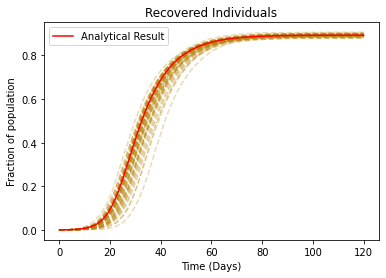

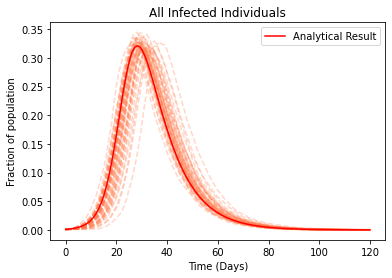

In [31]:
plt.title("Recovered Individuals")
for i in range(0,len(res)):
    plt.plot(res[i][:,0],res[i][:,4]/10000,'--',color='darkgoldenrod',alpha=0.3)
plt.plot(t,r,color='r',label="Analytical Result")
plt.legend()
plt.ylabel("Fraction of population")
plt.xlabel("Time (Days)")
plt.legend()
plt.savefig("./comparing_analytic_res_rec.png",dpi=100,facecolor='w')
plt.show()

plt.title("All Infected Individuals")
for i in range(0,len(res)):
    plt.plot(res[i][:,0],(res[i][:,2]+res[i][:,3]+res[i][:,5])/10000,'--',color='coral',alpha=0.3)
plt.plot(tee,eye+aye+ech,color='r',label="Analytical Result")
plt.legend()
plt.ylabel("Fraction of population")
plt.xlabel("Time (Days)")
plt.legend()
plt.savefig("./comparing_analytic_res_allinf.png",dpi=100,facecolor='w')
plt.show()

In [21]:

def an_soln(rate,Cpars,n0,T_max):
    
    n = np.copy(n0)
     
    N = np.sum(n0)
    print(N)
    t = np.linspace(0, T_max, T_max)# A grid of time points (in days)
    
    #########################################

    # The differential equations ############
    
    print(rate[0][1])
    print(rate[1][2])
    print(rate[1][3])
    print(rate[2][3])
    print(rate[2][4])
    print(rate[4][3])
    
    def deriv(y, t):
        [S, A, I, R, H] = y
        dSdt = - rate[0][1] * S * (Cpars[1]*A + Cpars[2]*I + Cpars[4]*H)/(N-H)
        dAdt = + rate[0][1] * S * (Cpars[1]*A + Cpars[2]*I + Cpars[4]*H)/(N-H) - (rate[1][2]+rate[1][3]) * A
        dIdt = + rate[1][2] * A - (rate[2][3] + rate[2][4]) * I
        dHdt = + rate[2][4] * I - rate[4][3] * H
        dRdt = + rate[1][3] * A + rate[2][3] * I + rate[4][3] * H
#         print(dSdt+dAdt+dIdt+dHdt+dRdt)
        return dSdt, dAdt, dIdt, dRdt, dHdt
    
    #########################################
    
    print(rate)
    
    y0 = n                              # Initial conditions vector
    ret = odeint(deriv, y0, t) # Integrate the SIR equations over the time grid, t.
    
    S, A, I, R, H = ret.T                                   # Return the transpose of the matrix

    return t, S/N, A/N, I/N, R/N, H/N

10000
0.45
0.205
0.136
0.1
0.25
0.1
[[0.    0.45  0.    0.    0.   ]
 [0.    0.    0.205 0.136 0.   ]
 [0.    0.    0.    0.1   0.25 ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.1   0.   ]]


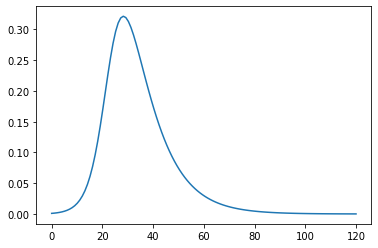

In [25]:
rate = np.copy(rate_array)

tee,ess,aye,eye,arr,ech = an_soln(rate, Cpars, n0, 120)
plt.plot(tee,eye+aye+ech)